In [134]:
import numpy as np
import pandas as pd
import seaborn as sn
import gensim
import spacy
import gensim.downloader as api 
from gensim.models import Word2Vec
# api.info() is showing all avialible gensim models
# this is all gensim models are listed here: https://github.com/piskvorky/gensim-data

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import GradientBoostingClassifier

# Gensim word2vec-google-news Model

In [87]:
wv = api.load('word2vec-google-news-300')  

In [7]:
wv.similarity("good","bad")
wv.most_similar("good", topn=5)

[('great', 0.7291510105133057),
 ('bad', 0.7190051078796387),
 ('terrific', 0.6889115571975708),
 ('decent', 0.6837348341941833),
 ('nice', 0.6836092472076416)]

In [9]:
wv.most_similar(positive=["france","berlin"], negative=["paris"], topn=5)
#france-paris+berlin

[('germany', 0.5094343423843384),
 ('european', 0.48650455474853516),
 ('german', 0.4714890420436859),
 ('austria', 0.46964022517204285),
 ('swedish', 0.4645182490348816)]

In [11]:
wv.doesnt_match(["dog", "cat", "google", "mouse"])

'google'

In [91]:
cosine_similarity([wv["great"],wv["good"]])[0][1]

0.729151

# Gensim Glove model

In [13]:
# gensim Glove model from standford University
# https://nlp.stanford.edu/projects/glove/

In [14]:
glv = api.load("glove-twitter-25")

In [17]:
glv.similarity("good","bad")
glv.most_similar("good",topn=5)

[('too', 0.9648017287254333),
 ('day', 0.9533665180206299),
 ('well', 0.9503170847892761),
 ('nice', 0.9438973665237427),
 ('better', 0.9425962567329407)]

In [18]:
glv.doesnt_match("breakfast cereal dinner lunch".split())

'cereal'

# Gensim Word2Vec Model based on our dataset

In [76]:
# Sample sentences for training the Word2Vec model

text = [
    "Gensim is a library for topic modeling.",
    "Word embeddings capture semantic model relationships.",
    "Machine learning models benefit from modelling word vectors.",
]

text_processed=[gensim.utils.simple_preprocess(i) for i in text]

# Create and train the Word2Vec model using Gensim API
model = Word2Vec(sentences=text_processed, vector_size=100, window=5, min_count=1, workers=4)

In [77]:
model.wv.most_similar("machine",topn=2)
model.wv["library"].shape

(100,)

In [81]:
model.wv.get_mean_vector(["embeddings", "model"])

array([ 0.00520314,  0.15264887,  0.04811689,  0.12725186,  0.07096256,
       -0.03322154,  0.07277728,  0.02004224, -0.10160024,  0.00060957,
        0.07749701, -0.02484779,  0.06808273, -0.05734866,  0.13832521,
       -0.04478195, -0.08495373, -0.07641201, -0.1031341 , -0.1042546 ,
       -0.03160974,  0.00542958,  0.09465685, -0.13623786, -0.05994345,
       -0.05481427, -0.08348947, -0.01989052,  0.04346938, -0.06820759,
        0.02835315, -0.11843323,  0.05329701,  0.09060298,  0.00038226,
        0.04739396, -0.00866848,  0.06378812, -0.03847633, -0.13232833,
       -0.09736572,  0.01979873,  0.01571685,  0.05706707, -0.02712453,
       -0.03581317,  0.09173247,  0.03717219, -0.05912133,  0.04485461,
        0.02401954, -0.0463328 ,  0.05854814, -0.00078209, -0.02653062,
       -0.02194951,  0.02600981,  0.05819736,  0.03658687, -0.08544386,
       -0.04370953, -0.03145005,  0.09343471, -0.03793086, -0.13704646,
        0.06195154,  0.03020018,  0.12809211, -0.1622059 ,  0.04

# Text classification using gensim-word2vec-google-news

In [95]:
df=pd.read_csv("Fake_Real_Data.txt")
df["label_num"]=df["label"].apply(lambda x: 1 if x=="Real" else 0)

In [104]:
nlp = spacy.load("en_core_web_lg")
def preprocess_vectorize(text):
    filtered_token=[]
    doc=nlp(text)
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        else:
            filtered_token.append(token.lemma_)
    return(wv.get_mean_vector(filtered_token))     

In [105]:
df["Text_new"]=df["Text"].apply(preprocess_vectorize)

In [108]:
df.to_csv("Fake_Real_Data_gensim.txt")

In [115]:
x_train,x_test,y_train, y_test=train_test_split(df["Text_new"],df.label_num,stratify=df.label_num,random_state=120)

In [124]:
x_train_2d=np.stack(x_train)
x_test_2d=np.stack(x_test)

In [125]:
model=GradientBoostingClassifier()
model.fit(x_train_2d,y_train)
ypred=model.predict(x_test_2d)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1250
           1       0.98      0.99      0.98      1225

    accuracy                           0.98      2475
   macro avg       0.98      0.98      0.98      2475
weighted avg       0.98      0.98      0.98      2475



<Axes: >

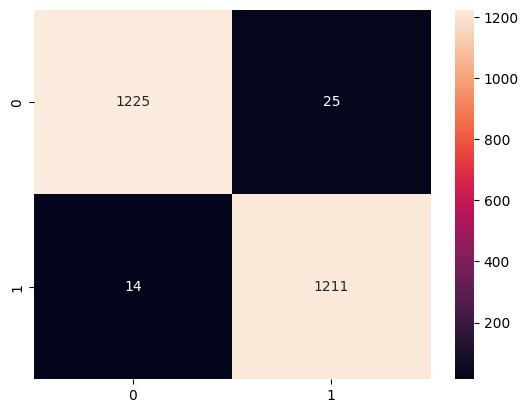

In [135]:
cm=confusion_matrix(y_test, ypred)
sn.heatmap(cm, annot=True, fmt='d')

In [132]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]


In [133]:
test_news_process=[preprocess_vectorize(i) for i in test_news]
test_news_process_2d=np.stack(test_news_process)
ypred_test=model.predict(test_news_process_2d)
ypred_test

array([1, 0, 0])